## Project 2 - Supervised machine learning on a kaggle video games sales dataset.
* Courtesy to **<a href="https://www.kaggle.com/datasets/gregorut/videogamesales">this kaggle post.</a>**

In [365]:
# Main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score

# Warnings filter in output
import warnings
warnings.filterwarnings("ignore")


### Main dataframe & EDA

In [366]:
df = pd.read_csv('vgsales.csv', date_parser=True).sort_values('Year').dropna().drop(columns=['Rank'])
df.columns = df.columns.str.lower()
df['year'] = df.year.astype(int)


df.isna().sum() # No NA in the data
# Normalize the data
df[df.select_dtypes(include='float').columns] *= 100
df[df.select_dtypes(include='float').columns] = df[df.select_dtypes(include='float').columns].astype(int)

df

,name,platform,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
6896,Checkers,2600,1980,Misc,Atari,22,1,0,0,24
2669,Boxing,2600,1980,Fighting,Activision,72,4,0,1,77
5366,Freeway,2600,1980,Action,Activision,32,2,0,0,34
1969,Defender,2600,1980,Misc,Atari,99,5,0,1,105
1766,Kaboom!,2600,1980,Misc,Activision,107,7,0,1,114
...,...,...,...,...,...,...,...,...,...,...
4820,EA Sports UFC 2,XOne,2016,Sports,Electronic Arts,23,14,0,4,40
16241,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017,Role-Playing,Sega,0,0,1,0,1
16438,Brothers Conflict: Precious Baby,PSV,2017,Action,Idea Factory,0,0,1,0,1
14390,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017,Role-Playing,Sega,0,0,3,0,3


In [367]:
# Class to visualize the data and the dataframe accordingly
class plotdata:
    def __init__(self, df, column):
        self.df = df
        self.column = column
    
    def plot_sales(self):
        df = self.df
        col = self.column
        df = df.groupby(col).agg({i:'sum' if i != 'name' and df[i].dtype==int or df[i].dtype==float else 'count' for i in df.columns.drop(col, 'rank')}).reset_index()
        if col == 'year': # Add a vertical line at the dropping point of number where at least 3 sales columns go closer to 0
            fig = px.line(df, x=col, y=df.columns.drop([col, 'year', 'publisher','genre']), title=f'N° Sales by <b>{col}</b>', width=1200)
            fig.add_vline(x=df[df.gt(4).sum(axis=1).ge(4)].year.max(), annotation_text="Important decline onward",annotation_position="right",line_dash="dot")
        elif col=='publisher': # Focus only on the top 20
            fig = px.bar(df.sort_values(by=[i for i in df.columns if 'sales' in i], ascending=False).head(20), x=col, y=[i for i in df.columns if 'sales' in i], title=f'N° Sales by <b>{col}</b>', color='variable', text='value', width=1200)

        else:
            fig = px.bar(df.sort_values(by=[i for i in df.columns if 'sales' in i], ascending=False), x=col, y=[i for i in df.columns if 'sales' in i], title=f'N° Sales by <b>{col}</b>', color='variable', text='value', width=1200)
        return fig.show()
    
    def get_dataframe(self):
        df = self.df
        col = self.column
        df = df.groupby(col).agg({i:'sum' if i != 'name' and i!='year' and df[i].dtype==int or df[i].dtype==float else 'count' for i in df.columns.drop(col, 'rank')}).reset_index()
        return df


In [368]:
# By genres
genres = plotdata(df, 'genre')
genres.plot_sales()
genres.get_dataframe()

,genre,name,platform,year,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,Action,3251,3251,3251,3251,86117,51614,15853,18481,172195
1,Adventure,1274,1274,1274,1274,10187,6374,5196,1669,23448
2,Fighting,836,836,836,836,22061,9990,8713,3616,44392
3,Misc,1686,1686,1686,1686,39670,21163,10662,7390,78948
4,Platform,875,875,875,875,44587,20057,13063,5146,82888
5,Puzzle,570,570,570,570,12195,5051,5667,1246,24206
6,Racing,1225,1225,1225,1225,35676,23616,5659,7667,72644
7,Role-Playing,1470,1470,1470,1470,32629,18747,35009,5938,92339
8,Shooter,1282,1282,1282,1282,57492,31023,3816,10184,102580
9,Simulation,848,848,848,848,18173,11297,6353,3133,38973


In [369]:
# By platforms
platforms = plotdata(df, 'platform')
platforms.plot_sales()
platforms.get_dataframe().head(10)

,platform,name,year,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,2600,116,116,116,116,8073,486,0,84,8651
1,3DO,3,3,3,3,0,0,10,0,10
2,3DS,499,499,499,499,7798,5825,9727,1255,24614
3,DC,52,52,52,52,543,169,855,27,1595
4,DS,2131,2131,2131,2131,38830,19397,17495,6024,81859
5,GB,97,97,97,97,11361,4750,8512,814,25440
6,GBA,786,786,786,786,17838,7246,4651,751,30547
7,GC,542,542,542,542,13185,3831,2134,513,19704
8,GEN,27,27,27,27,1927,552,267,89,2835
9,GG,1,1,1,1,0,0,4,0,4


In [370]:
# By year
year = plotdata(df, 'year')
year.plot_sales()
year.get_dataframe().tail()

,year,name,platform,genre,publisher,na_sales,eu_sales,jp_sales,other_sales,global_sales
34,2014,580,580,580,580,13191,12556,3946,3998,33687
35,2015,614,614,614,614,10276,9765,3371,3001,26437
36,2016,342,342,342,342,2264,2672,1367,774,7087
37,2017,3,3,3,3,0,0,5,0,5
38,2020,1,1,1,1,27,0,0,2,28


In [371]:
# By publisher
publisher = plotdata(df, 'publisher')
publisher.plot_sales()
publisher.get_dataframe().head()

,publisher,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,global_sales
0,10TACLE Studios,3,3,3,3,7,4,0,0,11
1,1C Company,3,3,3,3,1,7,0,2,10
2,20th Century Fox Video Games,5,5,5,5,182,10,0,1,194
3,2D Boy,1,1,1,1,0,3,0,1,4
4,3DO,36,36,36,36,648,304,0,63,1011


#### **Model selection** - Two models will be tested, both of which are supervised learning because we have labeled data, however, the problem is of multivariate regression type:
* **Linear regression** - simple regression formula, might cause some overfitting or underfitting...
* **Random Forest** - deeper understanding of the data (potentially more accurate), based on the robust ensemble method in which the sampling is not only on the row level but also on the feature one too.

##### 1. Linear Regression - Global Sales

<AxesSubplot: >

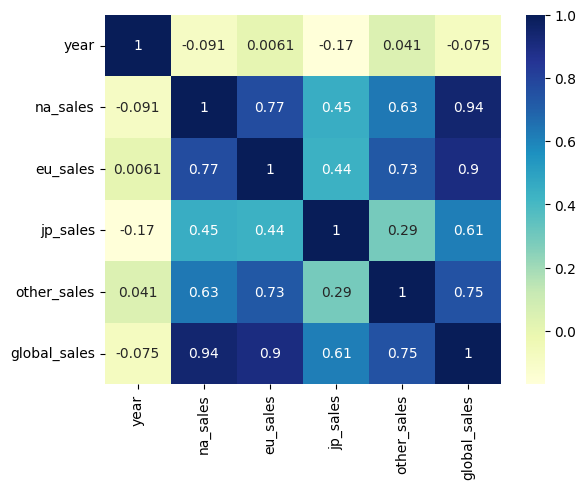

In [372]:
# View the correlation heatmap
# df.corr().style.background_gradient()
sns.heatmap(df.corr(), annot=True, cmap='YlGnBu')

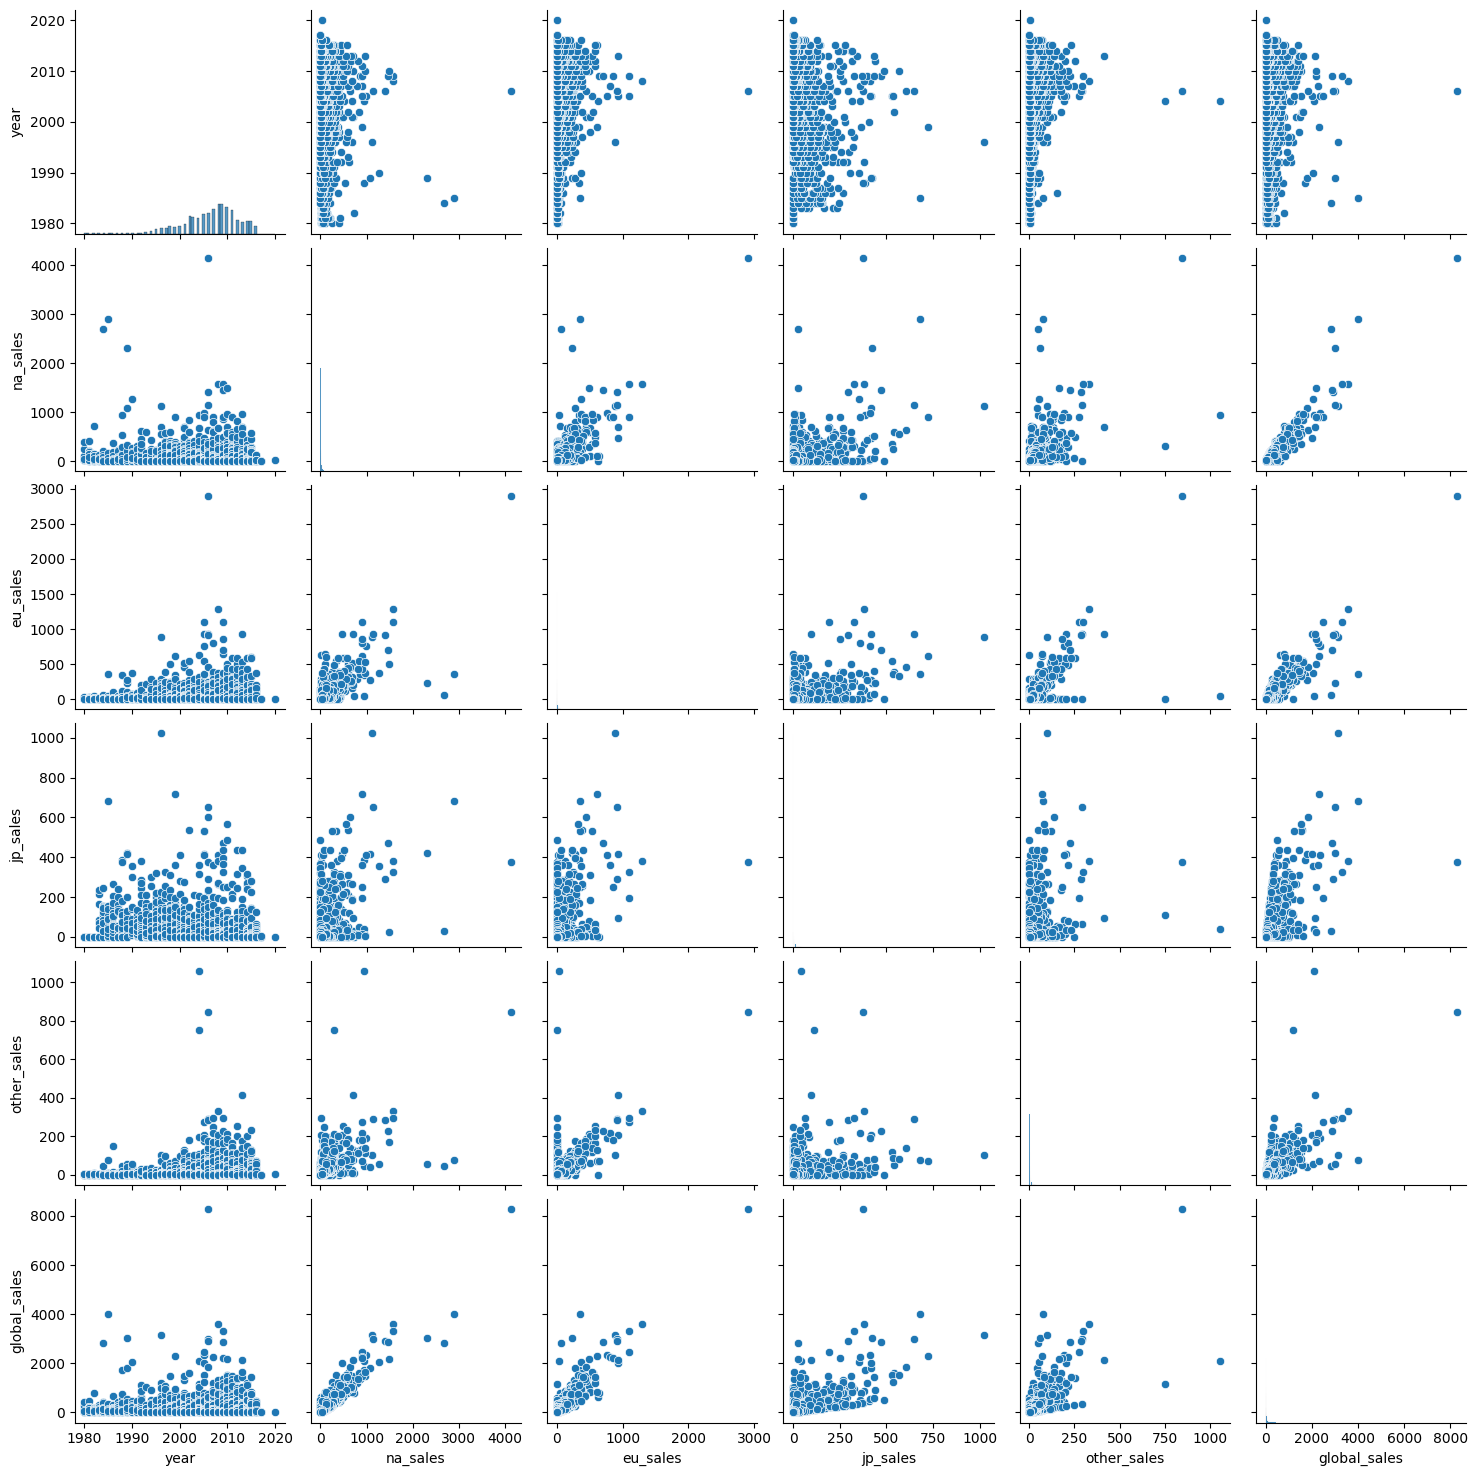

In [373]:
# Global overview of the correlation between the columns
sns.pairplot(df)

##### **On all the data**

In [374]:
# Train test split
x, y = df.drop(columns=['publisher','global_sales','name']), df.global_sales

# Encoding categorical variables
genre_encoder = LabelEncoder()
platform_encoder = LabelEncoder()

# encoder.fit_transform(x.platform)
x['genre'] = genre_encoder.fit_transform(x.genre)
x['platform'] = platform_encoder.fit_transform(x.platform)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=36, test_size=.25)

x_train

,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales
16513,13,2006,3,0,1,0,0
14682,4,2006,7,0,0,3,0
11582,19,2006,1,7,1,0,1
7705,28,2007,0,17,1,0,2
14843,16,2006,9,0,0,3,0
...,...,...,...,...,...,...,...
8664,4,2007,5,13,0,1,1
5516,16,2002,1,10,8,12,3
7839,16,2008,3,9,7,0,2
10142,21,1995,3,0,0,11,0


In [375]:
# Initiate model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Train the model
y_pred = lr.predict(x_test)
y_pred

array([121.03024177,  18.03462973,   9.0292317 , ...,   1.01671242,
        13.03418624,   6.02748895])

In [376]:
# R2 score test - 0.99, too perfect? Overfit?
r2 = r2_score(y_test, y_pred)
r2

0.9999859645748488

In [377]:
def to_predict(platform, year, genre, *args):
    selected_platform = platform_encoder.transform([platform.upper()])
    selected_genre = genre_encoder.transform([genre])
    return [[selected_platform[0], year, selected_genre[0], *args]]
    
# test_platform = input(f"Enter platform you'd like to predict from choices: {', '.join(df.platform.unique())}").upper()
# selected_platform = platform_encoder.transform([test_platform])

# test_genre = input(f"Enter genre you'd like to predict from choices: {', '.join(df.genre.unique())}")
# selected_genre = genre_encoder.transform([test_genre])


In [378]:
df.platform.unique(), df.genre.unique()

(array(['2600', 'NES', 'PC', 'DS', 'GB', 'SNES', 'GEN', 'GG', 'NG', 'SCD',
        'SAT', 'PS', '3DO', 'TG16', 'N64', 'PCFX', 'DC', 'WS', 'PS2',
        'GBA', 'XB', 'GC', 'PSP', 'X360', 'PS3', 'Wii', '3DS', 'PSV',
        'WiiU', 'PS4', 'XOne'], dtype=object),
 array(['Misc', 'Fighting', 'Action', 'Shooter', 'Sports', 'Platform',
        'Simulation', 'Racing', 'Puzzle', 'Adventure', 'Role-Playing',
        'Strategy'], dtype=object))

In [383]:
lr.predict(to_predict('NES', 1999, 'Action', 20, 24, 0, 9))

array([53.04529177])

In [355]:
print('\n\nTo predict:', list(genre_encoder.classes_)[3])
print('x_test df:\n', x_test.head(3)), 
print('y_test df:\n', y_test.head(3)), 




To predict: Misc
x_test df:
        platform  year  genre  na_sales  eu_sales  jp_sales  other_sales
1652         29  2001      3        93        24         0            4
7998         16  2004      2         9         7         0            2
10865        16  2001      7         2         2         4            1
y_test df:
 1652     121
7998      18
10865      9
Name: global_sales, dtype: int32


(None,)

##### **On categorical data & year only**
> As seen previously, the model is only focusing on the numerical variables as the primary predictor variables for the *global_sales* target variable<br><br>
##### This time however, it will be the random forest algorithm

In [436]:
x, y = df[['year','platform','genre','publisher']], df.global_sales

# Encoding categorical variables
genre_encoder = LabelEncoder()
platform_encoder = LabelEncoder()
publisher_encoder = LabelEncoder()

# encoder.fit_transform(x.platform)
x['genre'] = genre_encoder.fit_transform(x.genre)
x['platform'] = platform_encoder.fit_transform(x.platform)
x['publisher'] = publisher_encoder.fit_transform(x.publisher)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=36, test_size=.25)
x_train.head()

,year,platform,genre,publisher
16513,2006,13,3,160
14682,2006,4,7,472
11582,2006,19,1,487
7705,2007,28,0,499
14843,2006,16,9,275


In [437]:
rf = RandomForestRegressor()
rf_model = rf.fit(x_train, y_train)

y_pred = rf_model.predict(x_test)

In [438]:
x_test['y'], x_test['y_pred'] = y_test, y_pred

In [439]:
# R2 score test - 0.99, too perfect? Overfit?
r2 = r2_score(y_test, y_pred)
r2

-0.027672894549825244